## FERTILIZER RECOMMENDATION MODEL DEVELOPMENT

Some of our selected features from this dataset and their descriptions:

* `Nitrogen` : value of Nitrogen rate
* `Potassium` : value of Potassium rate
* `Phosphorus` : value of Phosphorus
* `Rainfall` : rainfall rate
* `Temperature` : rate of Temperature
* `Crop` : various crop names
* `Fertilizer`: various fertilizer names

In [5]:
# Importing the important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(font_scale=1.5,style="darkgrid")
sns.set_palette(['#ff826e', 'red'])
sns.set(rc={"axes.facecolor":'#faded9'})
%matplotlib inline

import pickle
import warnings
warnings.filterwarnings('ignore')

### Load dataset
Through this development process, we will follow the same process of crop recommendation however few changes need to be applied especially for feature scaling and encoding non-numerical data. 

In [91]:
df = pd.read_csv('New_crop_fertilizer_dataset.csv')
df.head()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop,Fertilizer
0,100,60,40,6.0,500,15,Wheat,19:19:19 NPK
1,105,60,40,6.0,500,15,Wheat,19:19:19 NPK
2,110,60,40,6.0,500,15,Wheat,19:19:19 NPK
3,115,60,40,6.0,500,15,Wheat,19:19:19 NPK
4,120,60,40,6.0,500,15,Wheat,19:19:19 NPK


### Data Preprocessing

In [7]:
# Check the summary information like null value, dtype of our features, ...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750 entries, 0 to 2749
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2750 non-null   int64  
 1   Phosphorus   2750 non-null   int64  
 2   Potassium    2750 non-null   int64  
 3   pH           2750 non-null   float64
 4   Rainfall     2750 non-null   int64  
 5   Temperature  2750 non-null   int64  
 6   Crop         2750 non-null   object 
 7   Fertilizer   2750 non-null   object 
dtypes: float64(1), int64(5), object(2)
memory usage: 172.0+ KB


In [8]:
# Mathematical descriprion for our dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Nitrogen,2750.0,107.278182,34.368238,20.0,85.0,120.0,135.0,150.0
Phosphorus,2750.0,59.994545,14.554434,15.0,50.0,60.0,70.0,90.0
Potassium,2750.0,71.354545,37.543133,20.0,45.0,55.0,100.0,150.0
pH,2750.0,6.723636,0.599795,5.5,6.5,6.5,7.0,8.5
Rainfall,2750.0,849.745455,273.940847,300.0,600.0,800.0,1000.0,1500.0
Temperature,2750.0,24.885455,5.982542,15.0,20.0,25.0,30.0,40.0


From this description, the major things we observe inside this dataset:
* Firstly, the mean, std values of all features varies in different range; this may lead to some features to dominate others which means that we need feature scaling depends on the choosen model to be utilized so that all features be in the same range(because not all models requires feature scaling).

In [69]:
# Check the shape of our features
df.dtypes

Nitrogen         int64
Phosphorus       int64
Potassium        int64
pH             float64
Rainfall         int64
Temperature      int64
Crop            object
Fertilizer      object
dtype: object

In [9]:
# check the size of our dataset
df.shape

(2750, 8)

In [10]:
# Check the presence of duplicated values
df.duplicated().sum()

38

This shows that in this dataset we have `38` duplicated values need to be removed

In [11]:
# Removing duplicate values
df = df.drop_duplicates()

In [12]:
# Split input features and target feature
X = df.drop('Fertilizer',axis=1)
y = df['Fertilizer']

In [13]:
# Continuous features
cont_features = ['Nitrogen','Phosphorus','Potassium','pH','Rainfall','Temperature']

# Let's find the outliers in our dataset
def find_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outlier = df[(df[feature]<lower_bound) | (df[feature]>upper_bound)]
    return outlier

for feature in cont_features:
    outlier = find_outliers(X,feature)
    print(f"The {feature} has {len(outlier)} potential outliers")

The Nitrogen has 0 potential outliers
The Phosphorus has 6 potential outliers
The Potassium has 0 potential outliers
The pH has 147 potential outliers
The Rainfall has 0 potential outliers
The Temperature has 0 potential outliers


In [14]:
# Let's remove those outliers appeared in our dataset for Phosphorus and pH features
outlier_features = ['Phosphorus','pH']

# Function to remove outliers
def remove_outliers(df,feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df[feature] = np.where(df[feature]<lower_bound,lower_bound,np.where(df[feature]>upper_bound,
                                                                       upper_bound,df[feature]))

for feature in outlier_features:
    remove_outliers(X,feature)

# Now we can whether the outliers are removed
for feature in X.select_dtypes(['int','float']).columns:
    outlier = find_outliers(X,feature)
    print(f"The {feature} has {len(outlier)} potential outliers")

The Nitrogen has 0 potential outliers
The Phosphorus has 0 potential outliers
The Potassium has 0 potential outliers
The pH has 0 potential outliers
The Rainfall has 0 potential outliers
The Temperature has 0 potential outliers


In [15]:
# Analyse the crop categorical input feature
df['Crop'].value_counts()

Crop
Sugarcane    1010
Wheat         824
Maize         350
Rice          309
Groundnut     174
Soybean        45
Name: count, dtype: int64

In [16]:
# Let's also analyse the target feature
df['Fertilizer'].value_counts()

Fertilizer
Urea                      1029
MOP                        472
19:19:19 NPK               445
DAP                        298
SSP                        224
50:26:26 NPK               124
Chilated Micronutrient     105
20:20:20 NPK                15
Name: count, dtype: int64

From this target feature, indicates that there is imbalance in our dataset for target feature. We can avoid this by oversapmling the data to keep balance between them.

In [17]:
# Before that, let's split the data into test and train dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [18]:
X_train['Crop'].value_counts()

Crop
Sugarcane    702
Wheat        567
Maize        252
Rice         214
Groundnut    130
Soybean       33
Name: count, dtype: int64

In [19]:
# Group or split continuous or categorical features
continuous_features = ['Nitrogen','Phosphorus','Potassium','pH','Rainfall','Temperature']
categorical_features = ['Crop']

In [20]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False,drop='first')

ct = ColumnTransformer(transformers=
                      [('scaler',scaler,continuous_features),
                      ('encoder',encoder,categorical_features)],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
ct.set_output(transform='pandas')
X_train = ct.fit_transform(X_train)

In [21]:
X_train.head()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Sugarcane,Crop_Wheat
2415,0.936145,1.012083,0.362870,-0.398977,-0.544129,-0.827830,0.0,0.0,0.0,1.0,0.0
916,0.501081,1.012083,-0.302439,-1.291970,-0.544129,0.847246,1.0,0.0,0.0,0.0,0.0
2144,1.226188,-0.019014,1.826551,-0.398977,0.193555,-0.827830,0.0,0.0,0.0,1.0,0.0
2572,0.356059,0.324685,1.560427,0.494016,2.037764,-0.827830,0.0,0.0,0.0,1.0,0.0
1589,-2.254328,-0.706412,-0.967748,1.387010,-0.544129,0.847246,0.0,0.0,0.0,0.0,0.0


In [22]:
# Transform test dataset features
X_test = ct.transform(X_test)
X_test.head()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Sugarcane,Crop_Wheat
516,-1.094156,-1.393809,-0.435501,1.387010,-0.912971,0.847246,0.0,0.0,0.0,0.0,1.0
1568,-2.254328,-1.393809,-1.366933,-1.291970,-0.912971,0.009708,0.0,0.0,0.0,0.0,0.0
1940,1.081167,1.355782,0.096747,1.833506,0.562396,-0.827830,0.0,0.0,0.0,1.0,0.0
2170,0.936145,1.355782,1.427365,0.494016,0.193555,-0.827830,0.0,0.0,0.0,1.0,0.0
2713,-1.529221,-1.737508,-1.233872,-0.398977,-1.650655,0.009708,0.0,0.0,1.0,0.0,0.0


In [23]:
# Let's oversample the train dataset
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Before smote: ',Counter(y_train))
# Perform SMOTE
smote=SMOTE(random_state=42)
# Oversample the train dataset
X_train_smote,y_train_smote=smote.fit_resample(X_train,y_train)

# The numbers after SMOTE
print("After smote:", Counter(y_train_smote))

Before smote:  Counter({'Urea': 716, 'MOP': 329, '19:19:19 NPK': 301, 'DAP': 212, 'SSP': 172, '50:26:26 NPK': 79, 'Chilated Micronutrient': 77, '20:20:20 NPK': 12})
After smote: Counter({'DAP': 716, 'SSP': 716, 'MOP': 716, 'Urea': 716, '19:19:19 NPK': 716, 'Chilated Micronutrient': 716, '50:26:26 NPK': 716, '20:20:20 NPK': 716})


In [24]:
# Here we are going back to check whether there is no duplicate values after Oversampling
train = X_train_smote.assign(Fertilizer=y_train_smote)
train.head()

,Nitrogen,Phosphorus,Potassium,pH,Rainfall,Temperature,Crop_Maize,Crop_Rice,Crop_Soybean,Crop_Sugarcane,Crop_Wheat,Fertilizer
0,0.936145,1.012083,0.362870,-0.398977,-0.544129,-0.827830,0.0,0.0,0.0,1.0,0.0,DAP
1,0.501081,1.012083,-0.302439,-1.291970,-0.544129,0.847246,1.0,0.0,0.0,0.0,0.0,SSP
2,1.226188,-0.019014,1.826551,-0.398977,0.193555,-0.827830,0.0,0.0,0.0,1.0,0.0,DAP
3,0.356059,0.324685,1.560427,0.494016,2.037764,-0.827830,0.0,0.0,0.0,1.0,0.0,MOP
4,-2.254328,-0.706412,-0.967748,1.387010,-0.544129,0.847246,0.0,0.0,0.0,0.0,0.0,SSP


In [25]:
# Check duplicate values
train.duplicated().sum()

0

After oversampling the train datase, we observe that there are no duplicated values in our training dataset

In [26]:
# We can check the shape of our dataset
train.shape

(5728, 12)

In [27]:
train['Fertilizer'].value_counts()

Fertilizer
DAP                       716
SSP                       716
MOP                       716
Urea                      716
19:19:19 NPK              716
Chilated Micronutrient    716
50:26:26 NPK              716
20:20:20 NPK              716
Name: count, dtype: int64

In [28]:
train.dtypes

Nitrogen          float64
Phosphorus        float64
Potassium         float64
pH                float64
Rainfall          float64
Temperature       float64
Crop_Maize        float64
Crop_Rice         float64
Crop_Soybean      float64
Crop_Sugarcane    float64
Crop_Wheat        float64
Fertilizer         object
dtype: object

In [29]:
# Here we split again our train dataset
X_train_smote,y_train_smote = train.drop('Fertilizer',axis=1), train['Fertilizer']

## Exploratory Data Analysis (EDA)

In [30]:
# Check the mathematical descriprion 
X_train_smote.describe().T

,count,mean,std,min,25%,50%,75%,max
Nitrogen,5728.0,-0.454179,1.219075,-2.544371,-1.614795,-0.139623,0.646102,1.226188
Phosphorus,5728.0,-0.393139,1.134687,-2.768605,-1.393809,-0.362713,0.572429,2.043179
Potassium,5728.0,-0.319218,0.981035,-1.366933,-1.100810,-0.568562,-0.302439,2.092674
pH,5728.0,-0.126122,0.985148,-1.738467,-1.291970,-0.398977,0.494016,1.833506
Rainfall,5728.0,-0.222498,1.132805,-2.019497,-1.135671,-0.226734,0.562396,2.406606
Temperature,5728.0,0.120349,0.898741,-1.665369,-0.827830,0.009708,0.847246,2.522323
Crop_Maize,5728.0,0.122730,0.328156,0.000000,0.000000,0.000000,0.000000,1.000000
Crop_Rice,5728.0,0.148568,0.355694,0.000000,0.000000,0.000000,0.000000,1.000000
Crop_Soybean,5728.0,0.133729,0.340391,0.000000,0.000000,0.000000,0.000000,1.000000
Crop_Sugarcane,5728.0,0.260999,0.439217,0.000000,0.000000,0.000000,1.000000,1.000000


As results, we can see that all features fall in the same range, no huge difference in mean, std. Which solved the problem of some features to be dominated by others with high values.

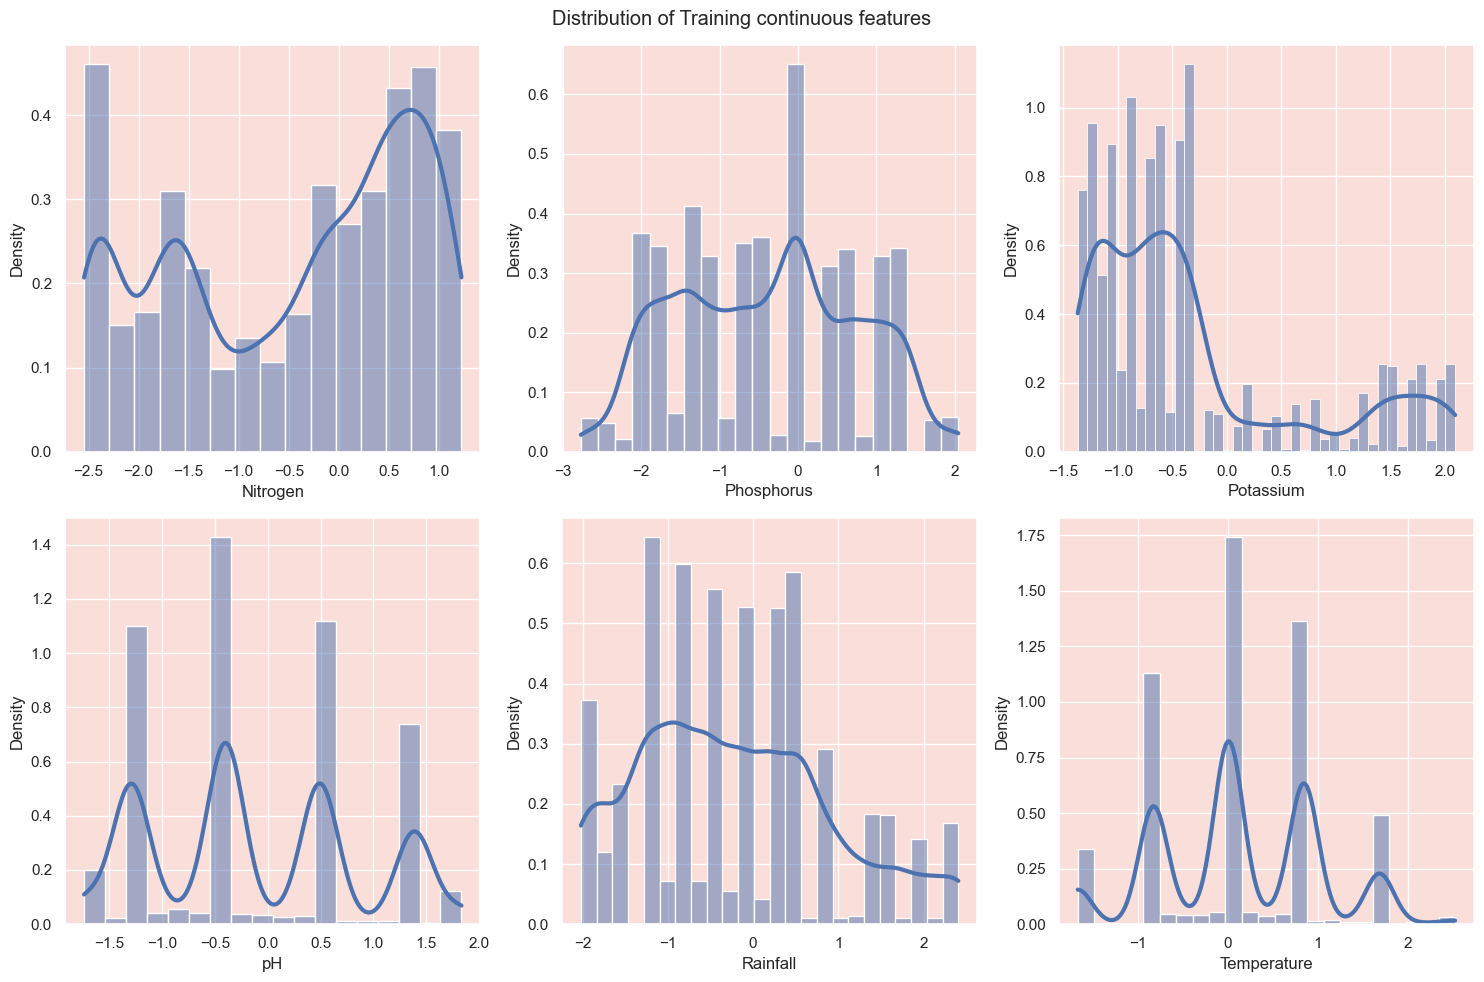

In [31]:
# Check the normal distribution of our continuous features
fig, ax = plt.subplots(2,3,figsize=(15,10))
for i,col in enumerate(continuous_features):
    x = i//3
    y = i%3
    sns.histplot(data=X_train_smote,x=X_train_smote[col],ax=ax[x,y],stat='density',
                 fill=True,kde=True,line_kws={'lw':3})
fig.suptitle("Distribution of Training continuous features")
fig.tight_layout();

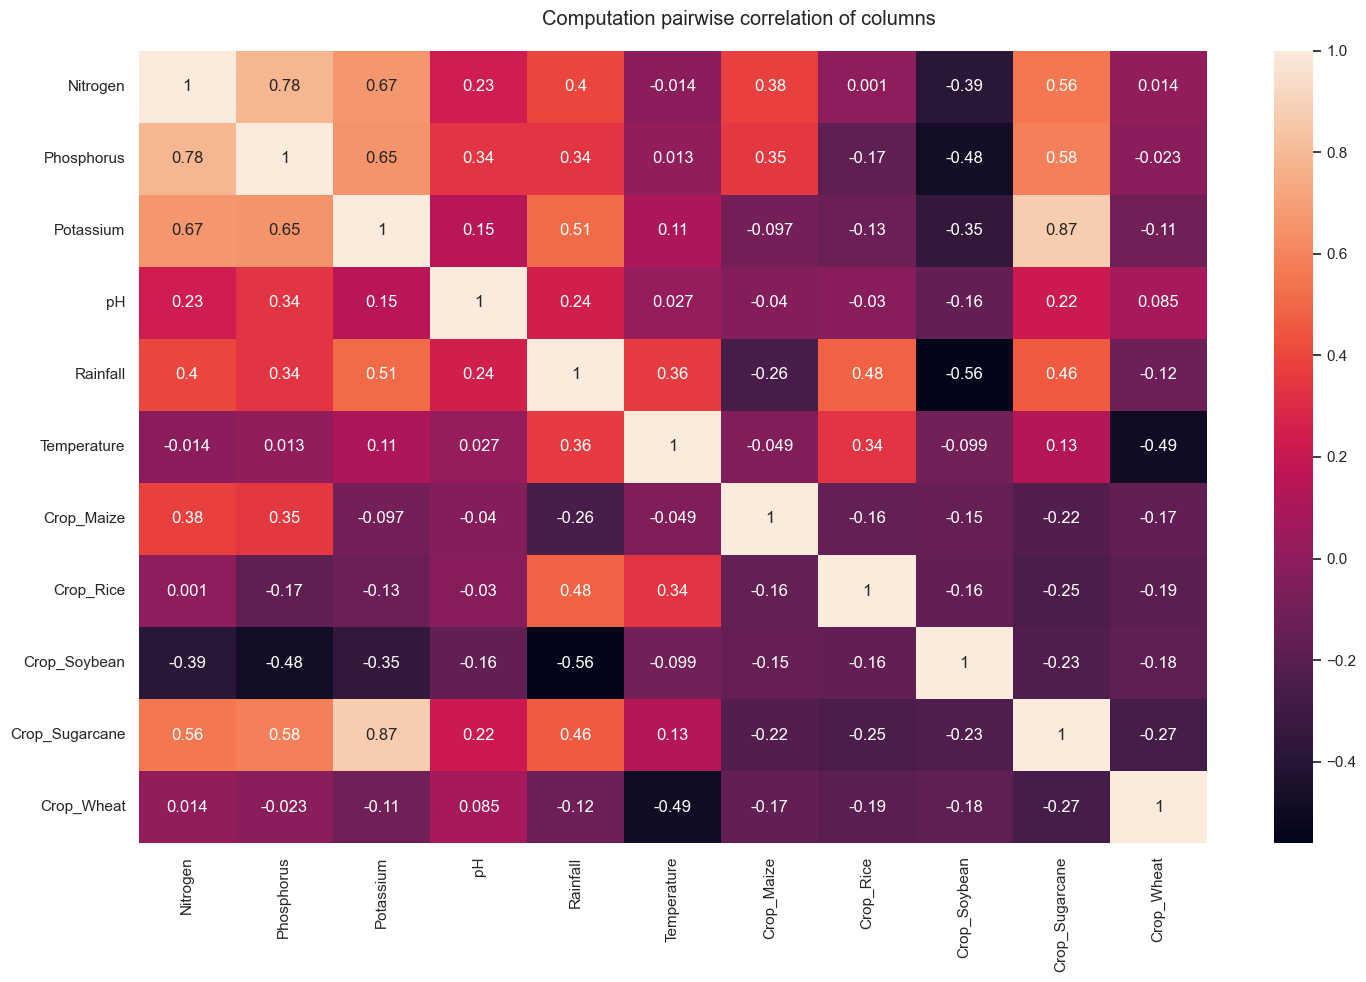

In [32]:
#  Let's also check the correlation between features
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(X_train_smote.corr(),annot=True,ax=ax)
fig.suptitle("Computation pairwise correlation of columns ")
fig.tight_layout();

From the above figure, we found that `4` features are having high correlation between them like `Nitrogen` and `Phosphorus`, `Potassium` and `X0_Sugarcane`. Which is not bad to our model performance.

## Model Development and Evaluation

In [33]:
# import model evaluation metrics
from sklearn.metrics import classification_report,accuracy_score,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score,f1_score

In [34]:
# Define model training function
def train_model(models,X_train_smote,y_train_smote,X_test,y_test):
    """
    This function is going to fit the model and find the scores
    """
    model_score = []
    for name, model in models.items():
        model.fit(X_train_smote,y_train_smote)
        y_pred = model.predict(X_test)
        
        #model performance evaluation
        accuracy = accuracy_score(y_test,y_pred)
        precision = precision_score(y_test,y_pred,average='micro')
        recall = recall_score(y_test,y_pred,average='micro')
        f1 = f1_score(y_test,y_pred,average='micro')
        
        # Lets join metrics into one dictionary
        model_score.append({
            'model name':name,
            'Precision':round(precision,2),
            'Recall':round(recall,2),
            'f1 score':round(f1,2),
            'accuracy':round(accuracy,2)
        })
    # Now we can view all three models evaluation results
    results = pd.DataFrame(model_score).sort_values(by='accuracy',ascending=False)
    return results      

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier

#Lets define a dictionary and a funtion to train different models
models = {
    'Logistic Regression':LogisticRegression(random_state=42),
    'knn':KNeighborsClassifier(),
    'forest':RandomForestClassifier(random_state=42),
    'extra_tree': ExtraTreesClassifier(random_state=42),
    'ada': AdaBoostClassifier(random_state=42)
}

all_metrics = train_model(models,X_train_smote,y_train_smote,X_test,y_test).set_index('model name')
all_metrics

,Precision,Recall,f1 score,accuracy
model name,,,,
extra_tree,0.97,0.97,0.97,0.97
forest,0.93,0.93,0.93,0.93
knn,0.87,0.87,0.87,0.87
Logistic Regression,0.43,0.43,0.43,0.43
ada,0.17,0.17,0.17,0.17


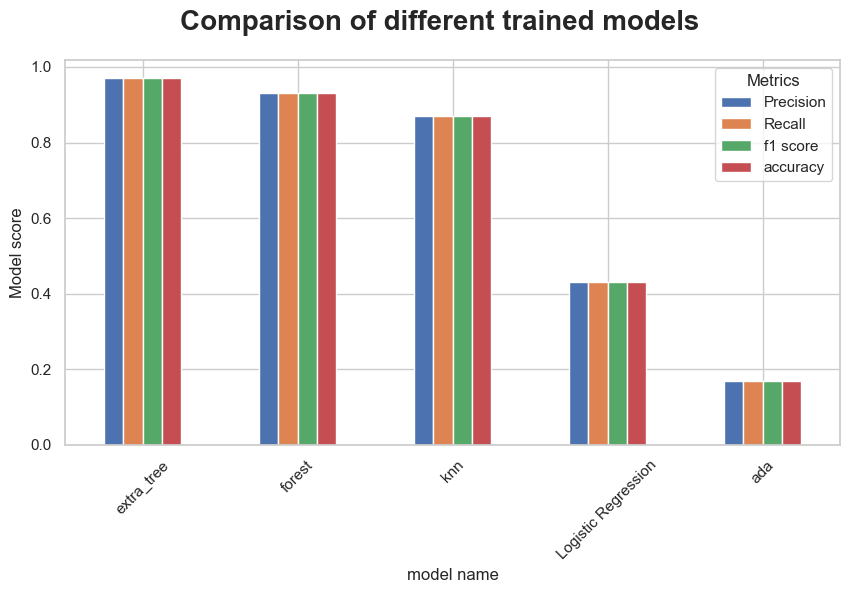

In [36]:
# Let's visualize this by using graph
sns.set_style(style='whitegrid')
all_metrics.plot.bar(figsize=(10,5))
plt.suptitle("Comparison of different trained models",fontsize=20,fontweight='bold')
plt.legend(title='Metrics')
plt.ylabel('Model score')
plt.xticks(rotation=45)
plt.show()

--> As result of 5 models evaluation, we obtained that `ExtraTreeClassifier` achieves more accuracy than others. This imply to the selection of best performance model to be used in the next step including integration.

In [37]:
# After selecting the model, we can retrain it as a single one
clf = ExtraTreesClassifier(random_state=42)
clf.fit(X_train_smote,y_train_smote)
y_pred = clf.predict(X_test)

In [38]:
clf.feature_names_in_

array(['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Rainfall',
       'Temperature', 'Crop_Maize', 'Crop_Rice', 'Crop_Soybean',
       'Crop_Sugarcane', 'Crop_Wheat'], dtype=object)

In [39]:
# Let's check whether there is no overfitting in our model
print("Training accuracy: ",clf.score(X_train_smote,y_train_smote))
print("Test performance accuracy: ",round(clf.score(X_test,y_test),2))

Training accuracy:  0.997032122905028
Test performance accuracy:  0.97


--> This shows that there is `no overfitting` between Training and Testing of our model

In [40]:
# Let's evaluate the accuracy score between y_test and y_pred
score = accuracy_score(y_test,y_pred)
print("The model accuracy score: ",round(score,2)*100,"%")

The model accuracy score:  97.0 %


In [41]:
# Let's try the classification report of our model
score2 = classification_report(y_test,y_pred)
print(score2)

                        precision    recall  f1-score   support

          19:19:19 NPK       0.94      0.94      0.94       144
          20:20:20 NPK       1.00      1.00      1.00         3
          50:26:26 NPK       1.00      1.00      1.00        45
Chilated Micronutrient       0.96      0.93      0.95        28
                   DAP       1.00      1.00      1.00        86
                   MOP       0.99      0.97      0.98       143
                   SSP       0.96      0.98      0.97        52
                  Urea       0.96      0.97      0.96       313

              accuracy                           0.97       814
             macro avg       0.98      0.97      0.98       814
          weighted avg       0.97      0.97      0.97       814



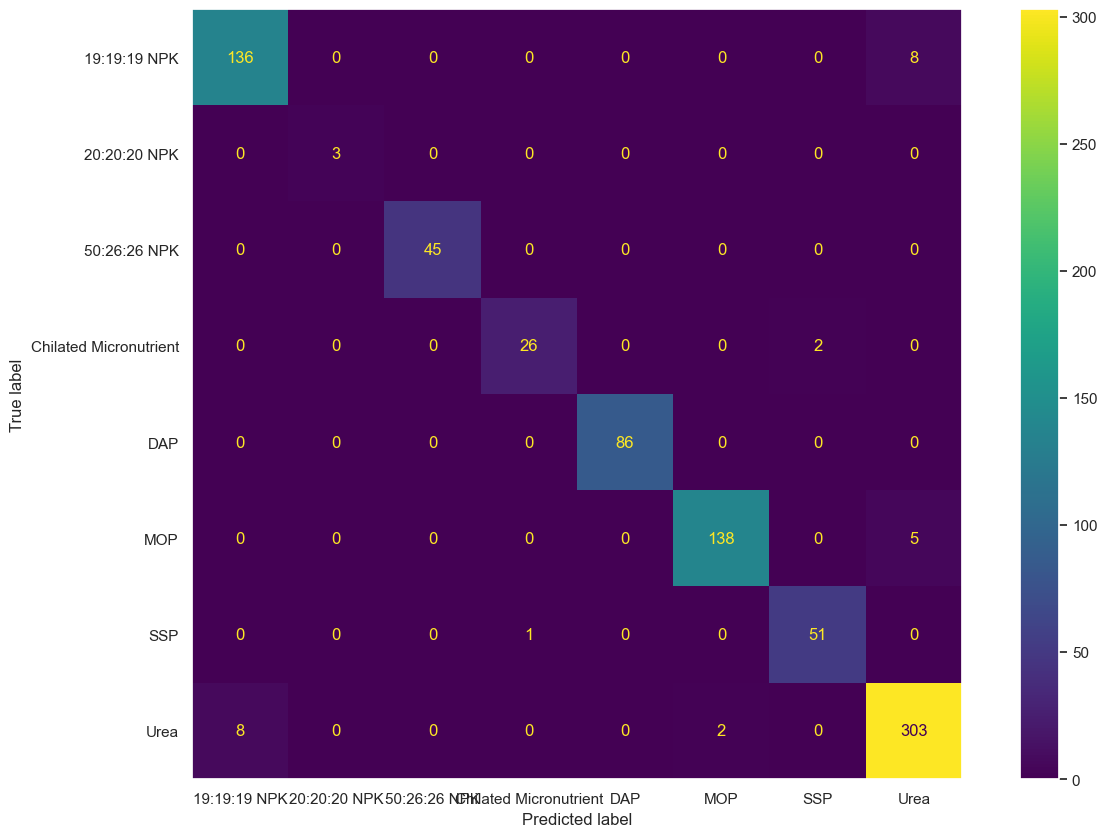

In [42]:
# Let's check the confussion matrix
sns.set(style='dark')
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=ax);

Above all the evaluations used, we can see that our model performance is good; Ready to be integrated in our system.

The time taken to calculate importance is 0.74 seconds



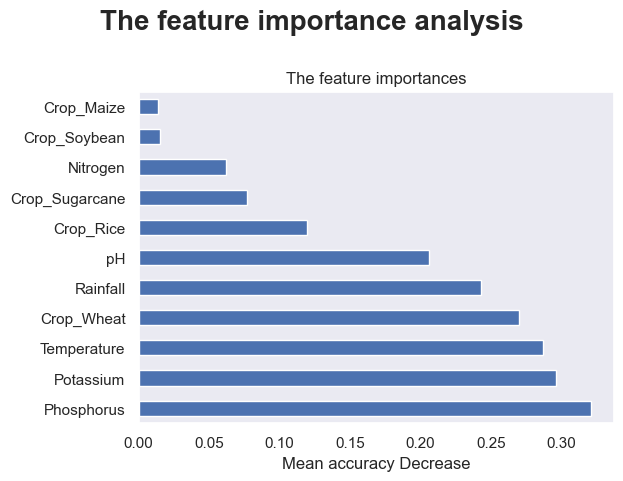

In [43]:
# Before saving our model, lets check the feature importance
from sklearn.inspection import permutation_importance
import time
start_time = time.time()
result = permutation_importance(clf,X_test,y_test)
print(f"The time taken to calculate importance is {time.time() - start_time :.2f} seconds")
print("")

feature_importances = pd.Series(result.importances_mean,index=train.columns[:-1]).sort_values(ascending=False)
fig,ax = plt.subplots()
feature_importances.plot.barh(ax=ax)
ax.set(title='The feature importances',
      xlabel = 'Mean accuracy Decrease')
fig.suptitle('The feature importance analysis',y=1,fontsize=20,fontweight='bold')
fig.tight_layout();

### Save our model

In [44]:
# Save model
pickle.dump(clf,open('fertilizer_recommendation_model.pkl','wb'))

### Load saved model

In [45]:
# Load saved model
model = pickle.load(open("fertilizer_recommendation_model.pkl","rb"))
round(model.score(X_test,y_test),2)

0.97